# Pure Audio

2024-11-18 22:43:46.930257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 22:44:18.862210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-18 22:44:18.862258: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-18 22:44:37.685763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Formato das embeddings (treino): (3196, 156, 128)
Formato dos rótulos (treino): (3196, 10)
Formato das embeddings (teste): (800, 156, 128)
Formato dos rótulos (teste): (800, 10)


2024-11-18 22:45:01.569541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-11-18 22:45:01.570059: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-18 22:45:01.570118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (missantroop): /proc/driver/nvidia/version does not exist
2024-11-18 22:45:01.623504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
200/200 [==============================] - 12s 34ms/step - loss: 4.4810 - categorical_accuracy: 0.1308 - precision: 0.1464 - recall: 0.0329 - val_loss: 3.8708 - val_categorical_accuracy: 0.1063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
200/200 [==============================] - 6s 32ms/step - loss: 3.8423 - categorical_accuracy: 0.1965 - precision: 0.4903 - recall: 0.0316 - val_loss: 3.7531 - val_categorical_accuracy: 0.1250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
200/200 [==============================] - 6s 32ms/step - loss: 3.5537 - categorical_accuracy: 0.3069 - precision: 0.6585 - recall: 0.0923 - val_loss: 3.3246 - val_categorical_accuracy: 0.3638 - val_precision: 1.0000 - val_recall: 0.0575
Epoch 4/100
200/200 [==============================] - 7s 34ms/step - loss: 3.2627 - categorical_accuracy: 0.3961 - precision: 0.6756 - recall: 0.1896 - val_loss: 2.8464 - val_categorical_accuracy: 0.5813 - val_precision: 0.9555 - va

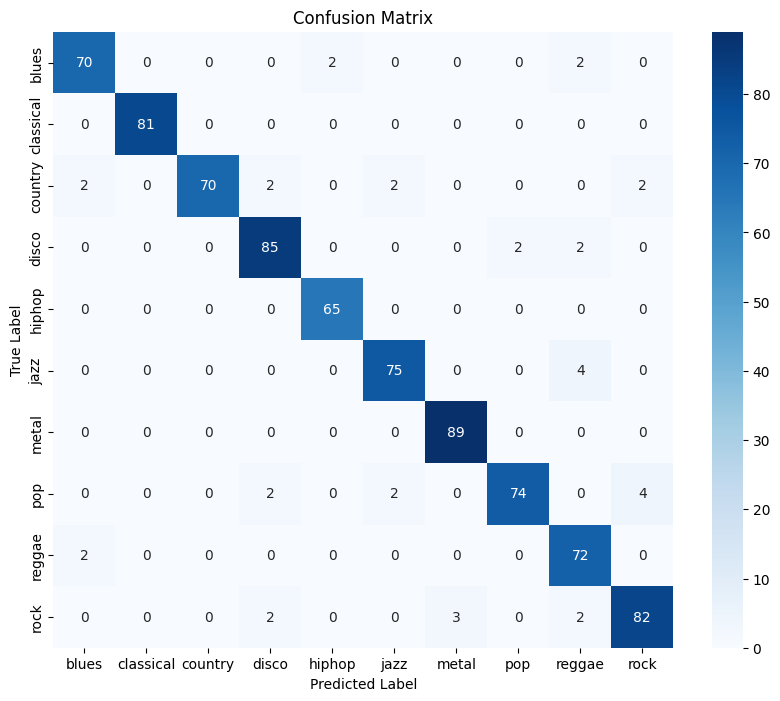

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.regularizers import l2

# Função para carregar embeddings e rótulos dos subdiretórios organizados por gênero
def load_embeddings_and_labels(embeddings_dir, expected_embedding_size=128):
    embeddings = []
    labels = []
    max_frames = 156  # Define o número de frames máximo

    for genre in os.listdir(embeddings_dir):
        genre_path = os.path.join(embeddings_dir, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                if file_name.endswith("_vggish.npy"):
                    file_path = os.path.join(genre_path, file_name)
                    data = np.load(file_path, allow_pickle=True).item()
                    embedding = data["embeddings"]
                    label = genre

                    # Ajustar o embedding para o tamanho fixo
                    if embedding.shape[0] < max_frames:
                        padded_embedding = np.pad(embedding, ((0, max_frames - embedding.shape[0]), (0, 0)), mode='constant')
                    else:
                        padded_embedding = embedding[:max_frames, :]

                    embeddings.append(padded_embedding)
                    labels.append(label)

    if not embeddings:
        raise ValueError("Nenhuma embedding válida encontrada no diretório.")

    embeddings = np.array(embeddings)
    embeddings = embeddings / np.max(np.abs(embeddings))  # Normalizar os dados
    return embeddings, labels

# Diretório das features extraídas e carregamento
embeddings_dir = '/home/missantroop/SongAnalysis2/mtg-jamendo-dataset/songresult_gtzan'
embeddings, labels = load_embeddings_and_labels(embeddings_dir)

# Aplicar data augmentation básico (opcional, aqui sem alterações)
augmented_embeddings = []
augmented_labels = []
for embedding, label in zip(embeddings, labels):
    augmented_embeddings.append(embedding)
    augmented_labels.append(label)

# Combinar os dados originais com os aumentados
embeddings = np.concatenate([embeddings, np.array(augmented_embeddings)])
labels = labels + augmented_labels

# Codificar os rótulos das classes em valores numéricos
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42
)

# Confirmar o formato dos dados para treinamento
print(f"Formato das embeddings (treino): {X_train.shape}")
print(f"Formato dos rótulos (treino): {y_train.shape}")
print(f"Formato das embeddings (teste): {X_test.shape}")
print(f"Formato dos rótulos (teste): {y_test.shape}")

# Calcular os pesos das classes
class_weights = compute_class_weight(
    'balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1)
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Função para criar o modelo CNN
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Ajuste de input_shape para o formato das embeddings
num_classes = y_train.shape[1]
model = create_cnn_model(input_shape=(156, 128), num_classes=num_classes)

# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(), Precision(), Recall()]
)

# Treinamento do modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Avaliação do modelo
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

# Geração de métricas detalhadas
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Audio with data augment

Formato das embeddings (treino): (1798, 156, 128)
Formato dos rótulos (treino): (1798, 10)
Formato das embeddings (teste): (200, 156, 128)
Formato dos rótulos (teste): (200, 10)
Epoch 1/100
113/113 [==============================] - 6s 34ms/step - loss: 4.8647 - categorical_accuracy: 0.1118 - precision_5: 0.1135 - recall_5: 0.0384 - val_loss: 3.8860 - val_categorical_accuracy: 0.1150 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/100
113/113 [==============================] - 3s 31ms/step - loss: 4.0537 - categorical_accuracy: 0.1663 - precision_5: 0.2015 - recall_5: 0.0150 - val_loss: 3.8363 - val_categorical_accuracy: 0.1750 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/100
113/113 [==============================] - 4s 31ms/step - loss: 3.8743 - categorical_accuracy: 0.1813 - precision_5: 0.3646 - recall_5: 0.0195 - val_loss: 3.7670 - val_categorical_accuracy: 0.1250 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/100
113/113 [===

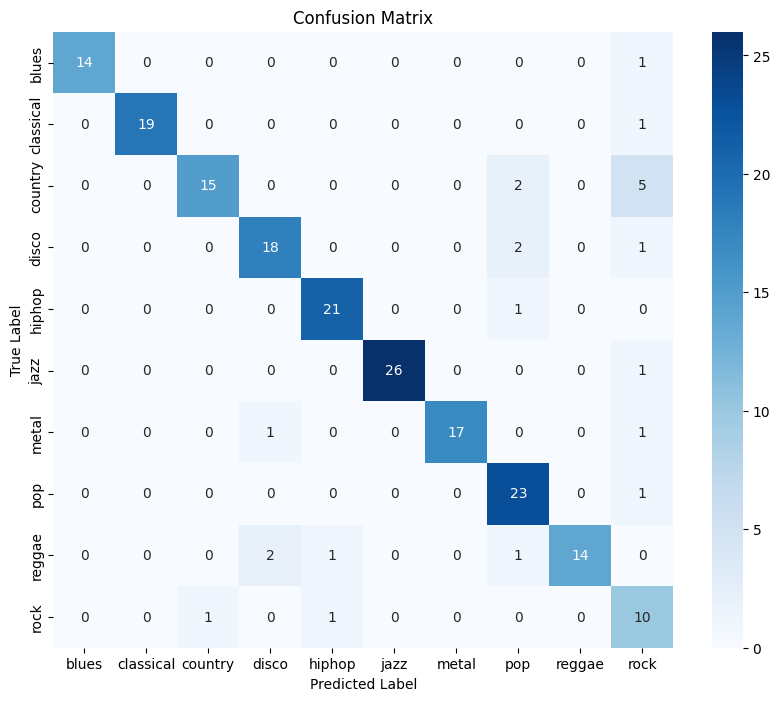

Epoch 1/100
113/113 [==============================] - 6s 34ms/step - loss: 0.9501 - categorical_accuracy: 0.9010 - precision_6: 0.9218 - recall_6: 0.8854 - val_loss: 1.3721 - val_categorical_accuracy: 0.8450 - val_precision_6: 0.8564 - val_recall_6: 0.8350
Epoch 2/100
113/113 [==============================] - 4s 31ms/step - loss: 0.9204 - categorical_accuracy: 0.8999 - precision_6: 0.9209 - recall_6: 0.8804 - val_loss: 1.1209 - val_categorical_accuracy: 0.8800 - val_precision_6: 0.8821 - val_recall_6: 0.8600
Epoch 3/100
113/113 [==============================] - 4s 31ms/step - loss: 0.9101 - categorical_accuracy: 0.9038 - precision_6: 0.9199 - recall_6: 0.8877 - val_loss: 1.1848 - val_categorical_accuracy: 0.8550 - val_precision_6: 0.8579 - val_recall_6: 0.8450
Epoch 4/100
113/113 [==============================] - 4s 32ms/step - loss: 0.8998 - categorical_accuracy: 0.9121 - precision_6: 0.9296 - recall_6: 0.8954 - val_loss: 1.1513 - val_categorical_accuracy: 0.8550 - val_precision_6

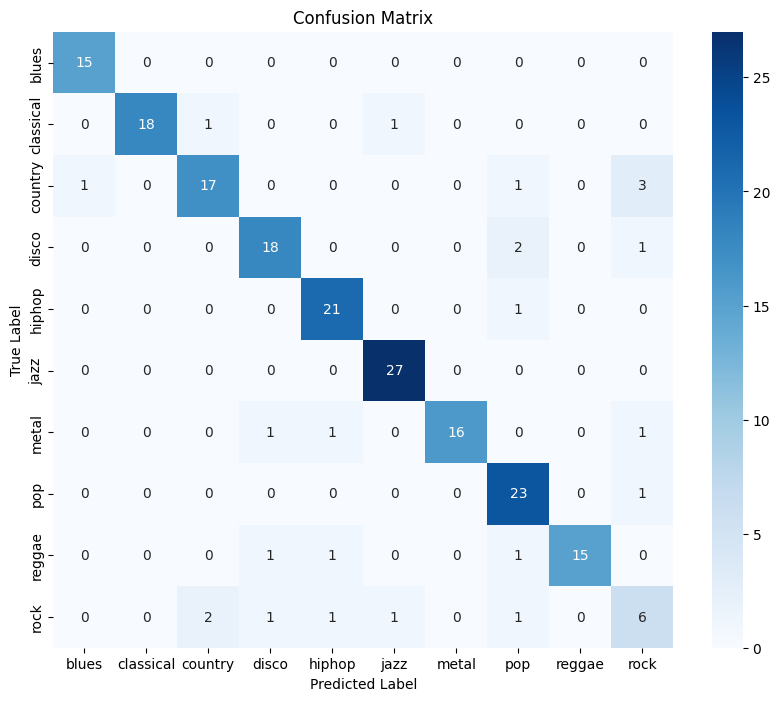

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.regularizers import l2

# Função para carregar embeddings e rótulos dos subdiretórios organizados por gênero
def load_embeddings_and_labels(embeddings_dir, expected_embedding_size=128):
    embeddings = []
    labels = []
    augmented_embeddings = []
    augmented_labels = []
    max_frames = 156  # Define o número de frames máximo

    for genre in os.listdir(embeddings_dir):
        genre_path = os.path.join(embeddings_dir, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                if file_name.endswith("_vggish.npy") or file_name.endswith("_augmented_vggish.npy"):
                    file_path = os.path.join(genre_path, file_name)
                    data = np.load(file_path, allow_pickle=True).item()
                    embedding = data["embeddings"]
                    label = genre

                    # Ajustar o embedding para o tamanho fixo
                    if embedding.shape[0] < max_frames:
                        padded_embedding = np.pad(embedding, ((0, max_frames - embedding.shape[0]), (0, 0)), mode='constant')
                    else:
                        padded_embedding = embedding[:max_frames, :]

                    # Separar os dados originais e os aumentados
                    if "_augmented_vggish.npy" in file_name:
                        augmented_embeddings.append(padded_embedding)
                        augmented_labels.append(label)
                    else:
                        embeddings.append(padded_embedding)
                        labels.append(label)

    if not embeddings:
        raise ValueError("Nenhuma embedding válida encontrada no diretório.")

    embeddings = np.array(embeddings)
    embeddings = embeddings / np.max(np.abs(embeddings))  # Normalizar os dados

    augmented_embeddings = np.array(augmented_embeddings)
    augmented_embeddings = augmented_embeddings / np.max(np.abs(augmented_embeddings))  # Normalizar os dados

    return embeddings, labels, augmented_embeddings, augmented_labels

# Diretório das features extraídas e carregamento
embeddings_dir = '/home/missantroop/SongAnalysis2/mtg-jamendo-dataset/songresult_gtzan'
embeddings, labels, augmented_embeddings, augmented_labels = load_embeddings_and_labels(embeddings_dir)

# Codificar os rótulos das classes em valores numéricos
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels)

augmented_labels = label_encoder.transform(augmented_labels)
augmented_labels = to_categorical(augmented_labels)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42
)

# Adicionar dados aumentados apenas ao conjunto de treino
X_train = np.concatenate([X_train, augmented_embeddings], axis=0)
y_train = np.concatenate([y_train, augmented_labels], axis=0)

# Confirmar o formato dos dados para treinamento
print(f"Formato das embeddings (treino): {X_train.shape}")
print(f"Formato dos rótulos (treino): {y_train.shape}")
print(f"Formato das embeddings (teste): {X_test.shape}")
print(f"Formato dos rótulos (teste): {y_test.shape}")

# Calcular os pesos das classes
class_weights = compute_class_weight(
    'balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1)
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Função para criar o modelo CNN
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Ajuste de input_shape para o formato das embeddings
num_classes = y_train.shape[1]
model = create_cnn_model(input_shape=(156, 128), num_classes=num_classes)

# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(), Precision(), Recall()]
)

# Treinamento do modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Avaliação do modelo
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

# Geração de métricas detalhadas
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(), Precision(), Recall()]
)

# Treinamento do modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Avaliação do modelo
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

# Geração de métricas detalhadas
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Data Extraction with data augment

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from vggish_input import waveform_to_examples
from vggish_postprocess import Postprocessor
import vggish_slim

tf.compat.v1.disable_eager_execution()

def define_model():
    vggish_slim.define_vggish_slim(training=False)

define_model()

# Função para aplicar data augmentation
def augment_audio(waveform, sample_rate):
    augmenter = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
        PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
        Shift(min_shift=-0.5, max_shift=0.5, p=0.5)  
    ])
    return augmenter(samples=waveform, sample_rate=sample_rate)


# Função para carregar áudio e extrair o espectrograma de Mel
def load_audio_and_extract_mel_spectrogram(file_path, augment=False):
    try:
        waveform, sr = librosa.load(file_path, sr=16000, mono=True)
        if augment:
            waveform = augment_audio(waveform, sr)
        mel_spectrogram = waveform_to_examples(waveform, sr)
        return mel_spectrogram
    except Exception as e:
        print(f"Erro ao carregar áudio {file_path}: {e}")
        return None

# Função para extrair embeddings usando o modelo VGGish
def extract_features_vggish(mel_spectrogram, model_path='vggish_model.ckpt', pca_path='vggish_pca_params.npz'):
    with tf.compat.v1.Session() as sess:
        saver = tf.compat.v1.train.Saver()
        try:
            saver.restore(sess, model_path)
            print("Modelo VGGish restaurado com sucesso!")
        except tf.errors.NotFoundError as e:
            print(f"Erro ao restaurar o modelo VGGish: {e}")
            return None

        features_tensor = sess.graph.get_tensor_by_name('vggish/input_features:0')
        embedding_tensor = sess.graph.get_tensor_by_name('vggish/embedding:0')
        [embedding] = sess.run([embedding_tensor], feed_dict={features_tensor: mel_spectrogram})

        pproc = Postprocessor(pca_path)
        embedding = pproc.postprocess(embedding)

    return embedding

# Função principal para processar áudio do GTZAN
def process_gtzan_audio(audio_directory, output_dir, augmentations=False):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for genre_folder in os.listdir(audio_directory):
        genre_path = os.path.join(audio_directory, genre_folder)
        if os.path.isdir(genre_path):
            print(f"Processando gênero: {genre_folder}")
            genre_output_dir = os.path.join(output_dir, genre_folder)
            if not os.path.exists(genre_output_dir):
                os.makedirs(genre_output_dir)

            for file_name in os.listdir(genre_path):
                if file_name.endswith(".mp3") or file_name.endswith(".wav"):
                    file_path = os.path.join(genre_path, file_name)
                    print(f"Processando arquivo: {file_name}")

                    # Extração de features com ou sem data augmentation
                    mel_spectrogram = load_audio_and_extract_mel_spectrogram(file_path, augment=False)
                    mel_spectrogram_augmented = load_audio_and_extract_mel_spectrogram(file_path, augment=augmentations) if augmentations else None

                    if mel_spectrogram is not None:
                        embeddings = extract_features_vggish(mel_spectrogram)
                        embeddings_augmented = extract_features_vggish(mel_spectrogram_augmented) if mel_spectrogram_augmented is not None else None

                        if embeddings is not None:
                            # Log do embedding e gênero
                            print(f"Embedding (primeiros 5 valores): {embeddings[:5]}")
                            print(f"Gênero associado: {genre_folder}\n")

                            # Salvar embeddings originais
                            output_data = {"embeddings": embeddings, "genre": genre_folder}
                            output_file = os.path.join(genre_output_dir, f"{os.path.splitext(file_name)[0]}_vggish.npy")
                            np.save(output_file, output_data)
                            print(f"Features salvos em: {output_file}")

                            # Salvar embeddings com augmentação, se aplicável
                            if embeddings_augmented is not None:
                                output_data_augmented = {"embeddings": embeddings_augmented, "genre": genre_folder}
                                augmented_output_file = os.path.join(genre_output_dir, f"{os.path.splitext(file_name)[0]}_augmented_vggish.npy")
                                np.save(augmented_output_file, output_data_augmented)
                                print(f"Features com augmentação salvos em: {augmented_output_file}")
                        else:
                            print(f"Erro: Embeddings não extraídos para {file_name}")
                    else:
                        print(f"Erro: Espectrograma de Mel não extraído para {file_name}")

# Configuração dos diretórios e execução do processamento
audio_directory = '/home/missantroop/SongAnalysis2/Data/genres_original'  # Substitua pelo caminho do dataset GTZAN
output_dir = '/home/missantroop/SongAnalysis2/mtg-jamendo-dataset/songresult_gtzan'  # Substitua pelo caminho do diretório de saída

# Ativar data augmentation
process_gtzan_audio(audio_directory, output_dir, augmentations=True)


# Lyrics CSV

In [ ]:
import csv

# Dados estruturados com os gêneros, artistas e músicas
music_data = [
    # Country
    {"Genre": "Country", "Artist": "Wayne Toups & Zydecajun", "Song": "Johnnie Can’t Dance"},
    
    # Disco
    {"Genre": "Disco", "Artist": "Billy Ocean", "Song": "Can You Feel It"},
    {"Genre": "Disco", "Artist": "Clarence Carter", "Song": "Patches"},
    {"Genre": "Disco", "Artist": "Latoya Jackson", "Song": "Playboy"},
    {"Genre": "Disco", "Artist": "Latoya Jackson", "Song": "(Baby) Do The Salsa"},
    {"Genre": "Disco", "Artist": "The Sugarhill Gang", "Song": "Rapper’s Delight"},
    {"Genre": "Disco", "Artist": "Evelyn Thomas", "Song": "Heartless"},
    {"Genre": "Disco", "Artist": "Evelyn Thomas", "Song": "Reflections"},
    
    # Hip Hop
    {"Genre": "Hip hop", "Artist": "3LW", "Song": "No More (Baby I’ma Do Right)"},
    {"Genre": "Hip hop", "Artist": "Aaliyah", "Song": "Try Again"},
    {"Genre": "Hip hop", "Artist": "Pink", "Song": "Can’t Take Me Home"},
    {"Genre": "Hip hop", "Artist": "Lauryn Hill", "Song": "Ex-Factor"},
    
    # Jazz
    {"Genre": "Jazz", "Artist": "Leonard Bernstein", "Song": "On the Town: Three Dance Episodes, Mvt. 1"},
    {"Genre": "Jazz", "Artist": "Leonard Bernstein", "Song": "Symphonic dances from West Side Story, Prologue"},
    
    # Metal
    {"Genre": "Metal", "Artist": "Creed", "Song": "I’m Eighteen"},
    {"Genre": "Metal", "Artist": "Living Colour", "Song": "Glamour Boys"},
    {"Genre": "Metal", "Artist": "The New Bomb Turks", "Song": "Hammerless Nail"},
    {"Genre": "Metal", "Artist": "The New Bomb Turks", "Song": "Jukebox Lean"},
    {"Genre": "Metal", "Artist": "The New Bomb Turks", "Song": "Jeers of a Clown"},
    {"Genre": "Metal", "Artist": "Queen", "Song": "Tie Your Mother Down"},
    {"Genre": "Metal", "Artist": "Queen", "Song": "Tear it up"},
    {"Genre": "Metal", "Artist": "Queen", "Song": "We Will Rock You"},
    {"Genre": "Metal", "Artist": "Def Leppard", "Song": "Pour Some Sugar On Me"},
    {"Genre": "Metal", "Artist": "Def Leppard", "Song": "Photograph"},
    {"Genre": "Metal", "Artist": "Deep Purple", "Song": "Smoke On The Water"},
    {"Genre": "Metal", "Artist": "Bon Jovi", "Song": "You Give Love A Bad Name"},
    {"Genre": "Metal", "Artist": "Rage Against The Machine", "Song": "Wake Up"},
    
    # Pop
    {"Genre": "Pop", "Artist": "Alanis Morissette", "Song": "You Oughta Know"},
    {"Genre": "Pop", "Artist": "Destiny’s Child", "Song": "Apple Pie a La Mode"},
    {"Genre": "Pop", "Artist": "Diana Ross", "Song": "Ain’t No Mountain High Enough"},
    {"Genre": "Pop", "Artist": "Prince", "Song": "The Beautiful Ones"},
    {"Genre": "Pop", "Artist": "Ladysmith Black Mambazo", "Song": "Leaning On The Everlasting Arm"},
    
    # Reggae
    {"Genre": "Reggae", "Artist": "Pras", "Song": "Ghetto Supastar (That Is What You Are)"},
    
    # Rock
    {"Genre": "Rock", "Artist": "Morphine", "Song": "I Know You Pt. III"},
    {"Genre": "Rock", "Artist": "Morphine", "Song": "Early To Bed"},
    {"Genre": "Rock", "Artist": "Morphine", "Song": "Like Swimming"},
    {"Genre": "Rock", "Artist": "Ani DiFranco", "Song": "Various Pieces (10–15)"},
    {"Genre": "Rock", "Artist": "Queen", "Song": "(You’re So Square) Baby I Don’t Care"},
    {"Genre": "Rock", "Artist": "The Beach Boys", "Song": "Good Vibrations"},
    {"Genre": "Rock", "Artist": "Billy Joel", "Song": "Movin’ Out"},
    {"Genre": "Rock", "Artist": "Guns N’ Roses", "Song": "Knockin’ On Heaven’s Door"},
    {"Genre": "Rock", "Artist": "Led Zeppelin", "Song": "The Crunge"},
    {"Genre": "Rock", "Artist": "Led Zeppelin", "Song": "The Wanton Song"},
    {"Genre": "Rock", "Artist": "Sting", "Song": "Consider Me Gone"},
    {"Genre": "Rock", "Artist": "Sting", "Song": "Moon Over Bourbon Street"},
    {"Genre": "Rock", "Artist": "Simply Red", "Song": "Various Pieces (71–78)"},
    {"Genre": "Rock", "Artist": "The Tokens", "Song": "The Lion Sleeps Tonight"},
]

# Nome do arquivo CSV
csv_file = "music_genres_updated.csv"

# Criar e salvar o CSV
with open(csv_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=["Genre", "Artist", "Song"])
    writer.writeheader()  # Escrever cabeçalho
    writer.writerows(music_data)  # Escrever os dados

print(f"Arquivo CSV '{csv_file}' criado com sucesso!")


# Lyric Scrapping

In [ ]:
import csv
import lyricsgenius
import time

# Configurações do Genius API
genius_access_token = 'EJhxVet_7D5eP7cl_HooGjVlwbzlM93rNXRNw1zDO6r-ojux4_pufzVm55pt9Y_K'  # Substitua pelo seu token de acesso
genius = lyricsgenius.Genius(genius_access_token)

# Carregar o CSV com as músicas
csv_file = "music_genres_updated.csv"

# Função para buscar a letra usando o Genius API
def get_lyrics(artist, song_title):
    try:
        # Procurar pela música no Genius
        song = genius.search_song(song_title, artist)
        if song:
            return song.lyrics
        else:
            return "Letra não encontrada."
    except Exception as e:
        print(f"Erro ao buscar a letra de {song_title} por {artist}: {e}")
        return "Erro ao buscar a letra."

# Ler o CSV e buscar as letras
with open(csv_file, mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    lyrics_data = []

    for row in reader:
        genre = row['Genre']
        artist = row['Artist']
        song = row['Song']
        
        # Buscar a letra da música
        print(f"Buscando letra de {song} por {artist}...")
        lyrics = get_lyrics(artist, song)
        
        # Adicionar as informações ao nosso registro
        lyrics_data.append({
            'Genre': genre,
            'Artist': artist,
            'Song': song,
            'Lyrics': lyrics
        })
        
        # Pausar para não sobrecarregar a API (limitar a 5 requisições por segundo)
        time.sleep(1)

# Salvar as letras no arquivo CSV
output_csv = "music_lyrics.csv"
with open(output_csv, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=['Genre', 'Artist', 'Song', 'Lyrics'])
    writer.writeheader()
    writer.writerows(lyrics_data)

print(f"Letras salvas no arquivo '{output_csv}' com sucesso!")


# Multimodal CNN

In [63]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def load_embeddings_and_labels(embeddings_dir, expected_embedding_size=128):
    embeddings = []
    labels = []
    augmented_embeddings = []
    augmented_labels = []
    max_frames = 156  # Define o número de frames máximo

    for genre in os.listdir(embeddings_dir):
        genre_path = os.path.join(embeddings_dir, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                if file_name.endswith("_vggish.npy") or file_name.endswith("_augmented_vggish.npy") or file_name.endswith("_embedding.npy"):
                    file_path = os.path.join(genre_path, file_name)
                    data = np.load(file_path, allow_pickle=True).item()
                    embedding = data["embeddings"]
                    label = genre

                    # Ajustar o embedding para o tamanho fixo
                    if embedding.shape[0] < max_frames:
                        padded_embedding = np.pad(embedding, ((0, max_frames - embedding.shape[0]), (0, 0)), mode='constant')
                    else:
                        padded_embedding = embedding[:max_frames, :]

                    # Separar os dados originais e os aumentados
                    if "_augmented_vggish.npy" in file_name:
                        augmented_embeddings.append(padded_embedding)
                        augmented_labels.append(label)
                        
                    else:
                        embeddings.append(padded_embedding)
                        labels.append(label)

    if not embeddings:
        raise ValueError("Nenhuma embedding válida encontrada no diretório.")

    embeddings = np.array(embeddings)
    embeddings = embeddings / np.max(np.abs(embeddings))  # Normalizar os dados

    augmented_embeddings = np.array(augmented_embeddings)
    augmented_embeddings = augmented_embeddings / np.max(np.abs(augmented_embeddings))  # Normalizar os dados

    return embeddings, labels, augmented_embeddings, augmented_labels

def load_lyrics_embeddings(embeddings_dir):
    embeddings = []
    labels = []
    max_frames = 156  # Define o número de frames máximo

    for file_name in os.listdir(embeddings_dir):
        if file_name.endswith("_embedding.npy"):
            file_path = os.path.join(embeddings_dir, file_name)
            try:
                embedding = np.load(file_path, allow_pickle=True)

                # Valida se o embedding é um array válido
                if not isinstance(embedding, np.ndarray):
                    raise ValueError(f"Arquivo inválido (não é um array): {file_name}")
                if embedding.ndim == 0:
                    raise ValueError(f"Arquivo vazio ou escalar: {file_name}")

                # Ajustar embedding para garantir 2D
                if embedding.ndim == 1:
                    embedding = np.expand_dims(embedding, axis=0)  # Transformar em 2D

                # Ajustar o tamanho do embedding
                if embedding.shape[0] < max_frames:
                    padded_embedding = np.pad(
                        embedding, 
                        ((0, max_frames - embedding.shape[0]), (0, 0)), 
                        mode='constant'
                    )
                else:
                    padded_embedding = embedding[:max_frames, :]

                embeddings.append(padded_embedding)
                labels.append(os.path.splitext(file_name)[0])  # Nome do arquivo como rótulo

            except Exception as e:
                print(f"Erro ao processar {file_name}: {e}")

    if not embeddings:
        raise ValueError("Nenhuma embedding válida encontrada no diretório.")

    embeddings = np.array(embeddings)

    # Normalizar se possível
    if np.max(np.abs(embeddings)) != 0:
        embeddings = embeddings / np.max(np.abs(embeddings))
    
    return embeddings, labels



# Carregar os embeddings e rótulos
audio_embeddings_dir = '/home/missantroop/SongAnalysis2/mtg-jamendo-dataset/songresult_gtzan'
lyrics_embeddings_dir = '/home/missantroop/SongAnalysis2/models/research/audioset/vggish/embeddings'  # Substitua pelo caminho correto

# Chamada da função corrigida
audio_embeddings, audio_labels, audio_augmented_embeddings, audio_augmented_labels = load_embeddings_and_labels(audio_embeddings_dir)
lyrics_embeddings, lyrics_labels, lyrics_augmented_embeddings, lyrics_augmented_labels = load_lyrics_embeddings(lyrics_embeddings_dir)

# Combinar os dados originais com os aumentados
audio_embeddings = np.concatenate([audio_embeddings, audio_augmented_embeddings], axis=0)
audio_labels += audio_augmented_labels

lyrics_embeddings = np.concatenate([lyrics_embeddings, lyrics_augmented_embeddings], axis=0)
lyrics_labels += lyrics_augmented_labels

# Verificar se os rótulos de áudio e texto correspondem
if set(audio_labels) != set(lyrics_labels):
    raise ValueError("Os gêneros de áudio e texto não correspondem!")

# Codificar os rótulos das classes em valores numéricos
label_encoder = LabelEncoder()
audio_labels = label_encoder.fit_transform(audio_labels)
audio_labels = to_categorical(audio_labels)

# Garantir que os rótulos estejam alinhados
if len(audio_embeddings) != len(lyrics_embeddings):
    raise ValueError("Número de embeddings de áudio e letras não corresponde!")

# Dividir os dados em conjuntos de treino e teste
X_train_audio, X_test_audio, X_train_lyrics, X_test_lyrics, y_train, y_test = train_test_split(
    audio_embeddings, lyrics_embeddings, audio_labels, test_size=0.2, random_state=42
)

# Confirmar o formato dos dados para treinamento
print(f"Formato das embeddings de áudio (treino): {X_train_audio.shape}")
print(f"Formato das embeddings de letras (treino): {X_train_lyrics.shape}")
print(f"Formato dos rótulos (treino): {y_train.shape}")

# Calcular os pesos das classes
class_weights = compute_class_weight(
    'balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1)
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Função para criar a CNN multimodal
def create_multimodal_cnn(input_shape_lyrics, input_shape_audio, num_classes):
    # Sub-rede para embeddings de letras
    lyrics_input = Input(shape=input_shape_lyrics, name="lyrics_input")
    x_lyrics = Conv1D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lyrics_input)
    x_lyrics = BatchNormalization()(x_lyrics)
    x_lyrics = MaxPooling1D(pool_size=2)(x_lyrics)
    x_lyrics = Dropout(0.3)(x_lyrics)
    
    x_lyrics = Conv1D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_lyrics)
    x_lyrics = BatchNormalization()(x_lyrics)
    x_lyrics = MaxPooling1D(pool_size=2)(x_lyrics)
    x_lyrics = Dropout(0.3)(x_lyrics)
    
    x_lyrics = Flatten()(x_lyrics)
    x_lyrics = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_lyrics)
    x_lyrics = Dropout(0.4)(x_lyrics)

    # Sub-rede para embeddings de áudio
    audio_input = Input(shape=input_shape_audio, name="audio_input")
    x_audio = Conv1D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(audio_input)
    x_audio = BatchNormalization()(x_audio)
    x_audio = MaxPooling1D(pool_size=2)(x_audio)
    x_audio = Dropout(0.3)(x_audio)
    
    x_audio = Conv1D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_audio)
    x_audio = BatchNormalization()(x_audio)
    x_audio = MaxPooling1D(pool_size=2)(x_audio)
    x_audio = Dropout(0.3)(x_audio)
    
    x_audio = Flatten()(x_audio)
    x_audio = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_audio)
    x_audio = Dropout(0.4)(x_audio)

    # Combinar as saídas das sub-redes
    combined = concatenate([x_lyrics, x_audio])

    # Camadas densas após a fusão
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(combined)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Criar o modelo
    model = Model(inputs=[lyrics_input, audio_input], outputs=output)
    return model

# Ajuste de input_shape para o formato dos embeddings
input_shape_lyrics = (X_train_lyrics.shape[1], X_train_lyrics.shape[2])
input_shape_audio = (X_train_audio.shape[1], X_train_audio.shape[2])
num_classes = y_train.shape[1]

# Criar o modelo multimodal
multimodal_model = create_multimodal_cnn(input_shape_lyrics, input_shape_audio, num_classes)

# Compilar o modelo
multimodal_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
multimodal_model.summary()

# Treinamento do modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = multimodal_model.fit(
    [X_train_lyrics, X_train_audio], y_train,
    epochs=100, batch_size=16,
    validation_data=([X_test_lyrics, X_test_audio], y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Avaliação do modelo
loss, accuracy = multimodal_model.evaluate([X_test_lyrics, X_test_audio], y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Geração de métricas detalhadas
y_pred = np.argmax(multimodal_model.predict([X_test_lyrics, X_test_audio]), axis=1)
y_true = np.argmax(y_test, axis=1)

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Erro ao processar song_37_embedding.npy: Arquivo vazio ou escalar: song_37_embedding.npy
Erro ao processar song_6_embedding.npy: Arquivo vazio ou escalar: song_6_embedding.npy
Erro ao processar song_15_embedding.npy: Arquivo vazio ou escalar: song_15_embedding.npy
Erro ao processar song_25_embedding.npy: Arquivo vazio ou escalar: song_25_embedding.npy
Erro ao processar song_17_embedding.npy: Arquivo vazio ou escalar: song_17_embedding.npy
Erro ao processar song_1_embedding.npy: Arquivo vazio ou escalar: song_1_embedding.npy
Erro ao processar song_27_embedding.npy: Arquivo vazio ou escalar: song_27_embedding.npy
Erro ao processar song_9_embedding.npy: Arquivo vazio ou escalar: song_9_embedding.npy
Erro ao processar song_39_embedding.npy: Arquivo vazio ou escalar: song_39_embedding.npy
Erro ao processar song_7_embedding.npy: Arquivo vazio ou escalar: song_7_embedding.npy
Erro ao processar song_35_embedding.npy: Arquivo vazio ou escalar: song_35_embedding.npy
Erro ao processar song_2_embe

ValueError: Nenhuma embedding válida encontrada no diretório.

In [58]:
import os

# Listar o conteúdo do diretório
lyrics_files = os.listdir(lyrics_embeddings_dir)
print(f"Arquivos no diretório '{lyrics_embeddings_dir}': {lyrics_files}")


Arquivos no diretório '/home/missantroop/SongAnalysis2/models/research/audioset/vggish/embeddings': ['song_37_embedding.npy', 'song_6_embedding.npy', 'song_15_embedding.npy', 'song_25_embedding.npy', 'song_17_embedding.npy', 'song_1_embedding.npy', 'song_27_embedding.npy', 'song_9_embedding.npy', 'song_39_embedding.npy', 'song_7_embedding.npy', 'song_35_embedding.npy', 'song_2_embedding.npy', 'song_30_embedding.npy', 'song_10_embedding.npy', 'song_14_embedding.npy', 'song_38_embedding.npy', 'song_3_embedding.npy', 'song_11_embedding.npy', 'song_43_embedding.npy', 'song_34_embedding.npy', 'song_40_embedding.npy', 'song_36_embedding.npy', 'song_46_embedding.npy', 'song_44_embedding.npy', 'song_23_embedding.npy', 'song_33_embedding.npy', 'song_20_embedding.npy', 'song_4_embedding.npy', 'song_45_embedding.npy', 'song_5_embedding.npy', 'song_18_embedding.npy', 'song_41_embedding.npy', 'song_24_embedding.npy', 'song_22_embedding.npy', 'song_29_embedding.npy', 'song_19_embedding.npy', 'song_2

In [ ]:
import os
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import re
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Diretório para salvar embeddings e metadados
output_dir = "embeddings"
os.makedirs(output_dir, exist_ok=True)

# Arquivo de metadados
metadata_file = os.path.join(output_dir, "metadata.csv")
if not os.path.exists(metadata_file):
    with open(metadata_file, "w") as f:
        f.write("filename,song,artist,genre\n")  # Cabeçalho do CSV

# Carregar dados
lyrics_data = pd.read_csv(
    "/home/missantroop/SongAnalysis2/models/research/audioset/vggish/music_lyrics.csv"
)  # CSV contendo letras

# Carregar o modelo LLaMA
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B", device_map="cpu")

# Configurar o token de preenchimento, se necessário
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


# Função para limpar o texto da letra
def clean_text(text):
    """Limpar o texto da letra, removendo caracteres especiais e convertendo para minúsculas."""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()


# Função para gerar embeddings das letras
def get_lyrics_embeddings(lyrics_text):
    """Gerar embedding da letra usando o modelo LLaMA."""
    inputs = tokenizer(lyrics_text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.logits.mean(dim=1)  # Média das saídas da última camada
    return embeddings


# Função para processar uma música e salvar os embeddings
def process_song(index, row):
    try:
        # Acessar valores da série como um dicionário
        song_title = row["Song"]
        artist_name = row["Artist"]
        lyrics = row["Lyrics"]
        genre = row["Genre"]

        # Validar se há letra disponível
        if pd.isnull(lyrics) or lyrics.lower() == "letra não encontrada.":
            logging.warning(f"Skipping song '{song_title}' by '{artist_name}' due to missing lyrics.")
            return False

        cleaned_lyrics = clean_text(lyrics)

        logging.info(f"Processing song '{song_title}' by '{artist_name}'")
        logging.info(f"Genre: {genre}")

        # Gerar embedding da letra
        lyrics_embeddings = get_lyrics_embeddings(cleaned_lyrics).cpu().numpy()

        # Validar o embedding
        if lyrics_embeddings.size == 0:
            logging.warning(f"Failed to generate valid embeddings for '{song_title}'. Skipping.")
            return False

        # Salvar embedding
        embedding_filename = f"song_{index}_embedding.npy"
        np.save(os.path.join(output_dir, embedding_filename), lyrics_embeddings)

        # Salvar metadados no CSV
        with open(metadata_file, "a") as f:
            f.write(f"{embedding_filename},{song_title},{artist_name},{genre}\n")

        logging.info(f"Embedding saved: {embedding_filename}")
        return True

    except Exception as e:
        logging.error(f"Error processing song '{row.get('Song', 'Unknown')}': {e}")
        return False


# Processar músicas sequencialmente
def process_lyrics_and_generate_embeddings():
    success_count = 0
    for index, row in lyrics_data.iterrows():
        if process_song(index, row):
            success_count += 1
    logging.info(f"Processing complete. Successfully processed {success_count}/{len(lyrics_data)} songs.")


# Executar o processamento
process_lyrics_and_generate_embeddings()

logging.info("Embeddings with genre correlation have been successfully saved.")
